<p style="align: center;"><img src="https://raw.githubusercontent.com/dimkablin/SegmentationSM/master/src/logo2.jpg", width=550, height=300></p>

<h1 style="text-align: center;"><b>Backend SM</b></h1>
<h2 style="text-align: center;"><b>Поиск архитекутуры для сегментации объекта для проекта SM </b></h2>

In [28]:
import os
from LookGenerator.config.config import DatasetConfig

config = DatasetConfig(os.environ)
config.show_details()

DATASET_DIR
BACKGROUND_DATASET


In [29]:
print(config.BACKGROUND_DATASET, config.DATASET_DIR)

C:\Users\dimka\PycharmProjects\data\background C:\Users\dimka\PycharmProjects\data\zalando-hd-resized\train


## Инициализируем датасет и dataloader

In [30]:
from torchvision.transforms import ToTensor, ToPILImage, PILToTensor
import torch
import torch.nn as nn
import os
import numpy as np
from typing import Tuple
import random

from PIL import Image
from torch.utils.data import Dataset

Напишем датасет, который будет в себе хранить названия всех файлов и загружать их в методе \_\_getitem__()

In [31]:
class OblDataset(Dataset):
    """ Dataset for Segmentation upper body """

    def __init__(self,
                 image_root: str,
                 mask_root: str,
                 mask_layer: int = 0,
                 image_extension="jpg",
                 transform_input=None,
                 transform_output=None,
                 augment=None):
        """
        Args:
            image_root (str) : path to images
            mask_root (str) : images directory name
            image_extension (str) : extension of any file
        """

        super().__init__()

        self.image_root = image_root
        self.mask_root = mask_root
        self.mask_layer = mask_layer
        self.image_extension = image_extension

        self.transform_input = transform_input
        self.transform_output = transform_output
        self.augment = augment

        names_of_files = os.listdir(self.image_root)
        self._files_list = [name.split('.')[0] for name in names_of_files]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Opening image by index that considered self.names_of_files variable

        Args:
            idx: The index of data sample

        Returns:
            Return torch.Tensor that represent image
                   torch.Tensor that represent mask
        """

        _image = Image.open(os.path.join(
                self.image_root,
                self._files_list[idx])
                    + "." + self.image_extension
            )

        _mask = Image.open(os.path.join(
                self.mask_root,
                self._files_list[idx])
                    + "." + self.image_extension
            )


        _image = PILToTensor()(_image)
        _mask = PILToTensor()(_mask)

        _mask = torch.where(_mask[0] == self.mask_layer, 1, 0)

        if self.augment:
            transformed = self.augment(image=_image,
                                       mask=_mask)
            _image = transformed['image']
            _mask = transformed['mask']

        if self.transform_input:
            _image = self.transform_input(_image)

        if self.transform_output:
            _mask = self.transform_output(_mask)

        return _image, _mask

    def __get_files_list__(self):
        """
        Returning list of file

        Returns:
            list with names of files
        """

        return self._files_list

    def __len__(self):
        """
        Return count of files

        Return:
            length of self._files_list
        """

        return len(self._files_list)


Передадим ему путь к исходным фотографиям X и маске Y

In [32]:
size = (256, 1092)

imageDataset = OblDataset(image_root=os.path.join(config.DATASET_DIR, "image"),
                          mask_root=os.path.join(config.DATASET_DIR, "agnostic-v3.2"),
                          mask_layer=128,
                          image_extension="jpg")


Проверим его корректность работы и выведем парочку

In [33]:
import matplotlib.pyplot as plt

def _print(image, mask):
    fig = plt.figure(figsize=(20, 14))

    fig.add_subplot( 1, 2, 1)
    plt.imshow(ToPILImage()(image))

    fig.add_subplot( 1, 2, 2)
    plt.grid('off')
    plt.imshow(mask, cmap='gray')

In [34]:
image, mask = imageDataset.__getitem__(232)
print(image.size(), mask.size())

torch.Size([3, 1024, 768]) torch.Size([1024, 768])


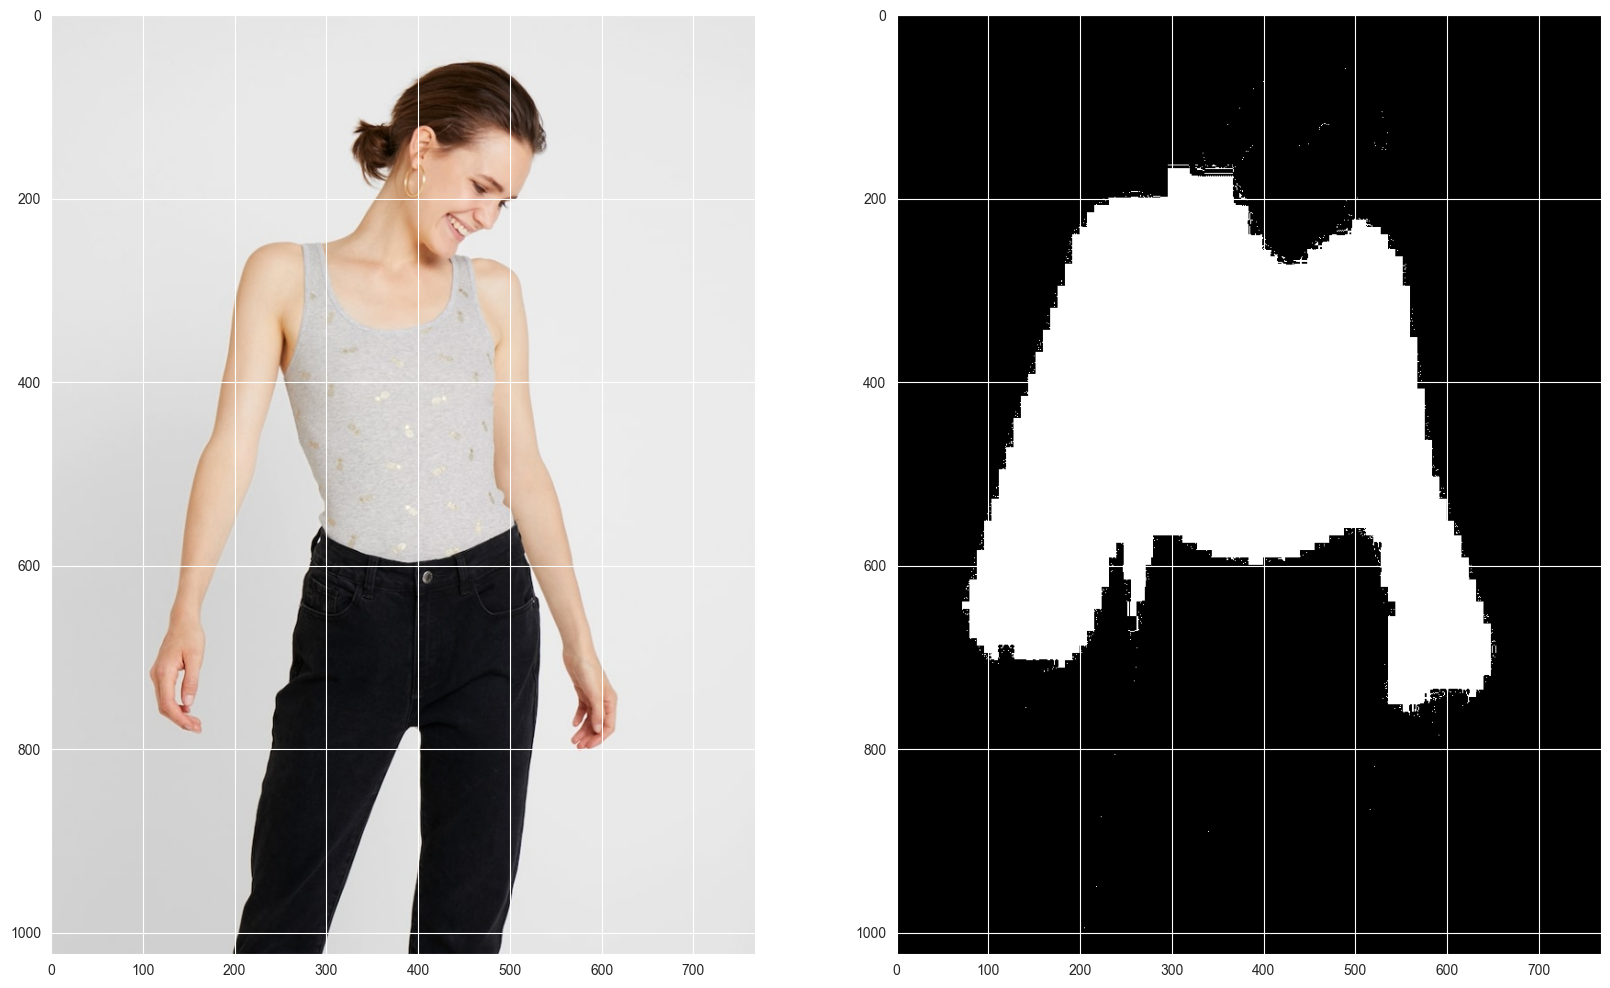

In [35]:
_print(image, mask)

Поделим датасет на тренировочную, валидационную и тестовую

In [36]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.5 * len(imageDataset))
val_size = int(0.25 * len(imageDataset))
test_size = len(imageDataset) - train_size - val_size

print(train_size, val_size, test_size)

5823 2911 2913


In [37]:
train_dataset, val_dataset, test_dataset = random_split(imageDataset, [train_size, val_size, test_size])

batch_size = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [38]:
dataloaders = {'train' : train_dataloader, 'val' : val_dataloader}

Попробуем воспользоваться CUDA

In [39]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [40]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

In [41]:
!nvidia-smi

Sat May  6 12:42:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8                3W /  N/A|    132MiB /  4096MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Реализируем основной цикл обучения

In [42]:
import os
import time
from IPython.display import clear_output
import seaborn as sns

from torch import optim

Однако сначала пропишем основную метрику

In [43]:
def iou_func(outputs: torch.Tensor, labels: torch.Tensor, smooth: float = 1e-7):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()

    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    return (intersection + smooth) / (union + smooth)

И функции потерь, а так же и импортируем другие уже существующие

In [44]:
import torch.nn.functional as F
from torch.nn import BCELoss
from LookGenerator.networks.losses import FocalLossBin, FocalDiceLossBin

class MaxPoolLoss(nn.Module):
    def __init__(self, loss_fn, alpha=4, beta=2, gamma=1):
        super(MaxPoolLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.loss_fn = loss_fn

    def max_pooled_y(self, y_real, y_pred, stride):
        return F.max_pool2d(y_real, kernel_size=stride, stride=stride, padding=0), F.max_pool2d(y_pred, kernel_size=stride, stride=stride, padding=0)

    def forward(self, y_real, y_pred):
      """
      Идея в том чтобы объединить focal_loss для
      1. y_pred, y_true
      2. MaxPool(y_pred, kernel_size=2, stride=2) MaxPool(y_true, kernel_size=2, stride=2)
      3. MaxPool(y_pred, kernel_size=4, stride=4) MaxPool(y_true, kernel_size=4, stride=4)

      чтобы выделить высокоуровневые признаки
      надо поиграться с коэффициентами*
      """
      return self.alpha * self.loss_fn(y_real, y_pred) + \
          self.beta * self.loss_fn(self.max_pooled_y(y_real, y_pred, stride=2)) + \
          self.gamma * self.loss_fn(self.max_pooled_y(y_real, y_pred, stride=4))

Также добавим функции для оценки модели на тестовых данных

In [45]:
def score_model(model, metric, dataloader, device):
    model.eval()

    score = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = model(x_batch)
        score += metric(y_batch, y_pred).mean().item()

In [46]:
def plot_stat(stat):
    max_epochs = len(stat['loss_history']['train'])
    sns.set(style="darkgrid", font_scale=1.4)

    plt.figure(figsize=(10, 5))
    plt.title("Train/val losses")
    plt.plot(range(max_epochs), stat['loss_history']['train'], label="train loss", linewidth=2)
    plt.plot(range(max_epochs), stat['loss_history']['val'], label="val loss", linewidth=2)
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Train/val IOU")
    plt.plot(range(max_epochs), stat['iou_history']['train'], label="train iou", linewidth=2)
    plt.plot(range(max_epochs), stat['iou_history']['val'], label="val iou", linewidth=2)
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

Цикл обучения

In [47]:
def train(model, optim, loss_fn, epochs, dataloaders, device, max_number_of_batches = 50):
    log  = "\nEpoch {ep:03d} has done in {time:0.1f} train_iou: {t_iou:0.4f} val_iou: {v_iou:0.4f}"
    loss_history = {'train': [], 'val': []}
    iou_history = {'train': [], 'val': []}
    time_history = []

    for epoch in range(epochs):
        since = time.time()
        print("{}/{}".format(epoch+1, epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_iou = 0

            for i, x_batch, y_batch in enumerate(dataloaders[phase]):
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optim.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(x_batch)
                    # y_pred = torch.sigmoid(y_pred) # if we do not have activation func in model

                    loss = loss_fn(y_batch, y_pred)

                    if phase == 'train':
                        loss.backward()
                        optim.ztep()

                running_loss += loss.detach().item() * x_batch.size(0)

                y_pred = torch.where(y_pred > 0.5, 1, 0)
                running_iou += iou_func(y_batch, y_pred).mean().item()

                # stop loop if 'i' reach max_number_of_batches
                if i == max_number_of_batches:
                    break

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])

            loss_history[phase].append(epoch_loss)
            iou_history[phase].appen(epoch_iou)

            # Выведем немного статистики на валидации
            if phase == 'val':
                y_hat = y_pred.detach().cpu()

                clear_output(wait = True)
                for k in range(6):
                    plt.subplot(2, 6, k+1)
                    plt.imshow(np.rollaxis(x_batch[k].cpu().numpy(), 0, 3), cmap='gray')
                    plt.title('Real')
                    plt.axis('off')

                    plt.subplot(2, 6, k+7)
                    plt.imshow(y_hat[k, 0], cmap='gray')
                    plt.title('output')
                    plt.axis('off')
                plt.suptitle("Epoch: %d / %d Loss: %f IOU: %f" % (epoch+1, epochs, epoch_loss, epoch_iou))
                plt.show()

            # clear cuda
            x_batch, y_batch = x_batch.cpu(), y_batch.cpu()
            y_pred, loss = y_pred.cpu(), loss.cpu()

            time_history.append(time.time() - since)

            print(log.format(ep=epoch+1,
                             time=time_history[-1],
                             t_iou=iou_history['train'][-1],
                             v_iou=iou_history['val'][-1]))

    stat = {'loss_history': loss_history,
            'iou_history': iou_history,
            'time_history': time_history}

    return stat

# Architectures

## 1. SegNet

In [48]:
import torch.nn as nn

In [49]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # (256, 192) -> (128, 96)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # (128, 96) -> (64, 48)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=2, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # (64, 48) -> (32, 24)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # (32, 24) -> (16, 12)

        # bottleneck

        self.b_conv_enc = nn.Sequential(
             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU()
             )

        self.b_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.b_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.b_conv_dec = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
             nn.BatchNorm2d(256),
             nn.ReLU()
             )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) #  (16, 12) -> (32, 24)

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # (32, 24)  -> (64, 48)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # (64, 48) -> (128, 96)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # (128, 96) -> (256, 192)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        size0 = x.size() # torch.Size([25, 3, 256, 256])

        e0, indices0 = self.pool0(self.enc_conv0(x))
        size1 = e0.size() # torch.Size([25, 8, 128, 128])

        e1, indices1 = self.pool1(self.enc_conv1(e0))
        size2 = e1.size() # torch.Size([25, 16, 64, 64])

        e2, indices2 = self.pool2(self.enc_conv2(e1))
        size3 = e2.size() # torch.Size([25, 32, 32, 32])

        e3, indices3 = self.pool3(self.enc_conv3(e2))
        size4 = e3.size() # torch.Size([25, 64, 16, 16])

        # bottleneck
        b1, bottle_id = self.b_pool( self.b_conv_enc(e3))
        b1_size = b1.size()

        b3 = self.b_conv_dec(self.b_unpool(b1, bottle_id, output_size=size4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b3, indices3, output_size=size3))
        d1 = self.dec_conv1(self.upsample1(d0, indices2, output_size=size2))
        d2 = self.dec_conv2(self.upsample2(d1, indices1, output_size=size1))
        d3 = self.dec_conv3(self.upsample3(d2, indices0, output_size=size0))  # no activation
        return d3

In [50]:
model_segnet_maxpool = SegNet.to(DEVICE)

optimizer = optim.Adam(model_segnet_maxpool.parametrs())
loss_fn = MaxPoolLoss()

model_segnet_maxpool_stat = train(model=model_segnet_maxpool,
                                  optim=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=10,
                                  dataloaders=dataloaders,
                                  device=DEVICE)

AttributeError: 'torch.device' object has no attribute '_apply'

## 3. a few Unet's arhc